### Load data

In [1]:
import common
import pandas as pd
data_df, lects_df = common.load_lexirumah()
display(data_df.head())
display(lects_df.head())




Loading data...
Loaded data.


,ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment,Source
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10]
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10]
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10]
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10]
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10]


,ID,Name,Family,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment,Macroarea
0,abui1241-fuime,"Abui, Fuimelang",Timor-Alor-Pantar,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-petle,"Abui, Petleng",Timor-Alor-Pantar,-8.2144,124.593,"Kecamatan Teluk Mutiara, Kabupaten Alor, East ...",abui1241,abz,None,None,"[p/general, p/abui1241-petle]",None,Papunesia
2,abui1241-takal,"Abui, Takalelang",Timor-Alor-Pantar,-8.1887,124.6264,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,abui,None,"[p/general, p/abui1241-takal]",None,Papunesia
3,abui1241-ulaga,"Abui, Ulaga",Timor-Alor-Pantar,-8.403792,124.623702,"Kecamatan Alor Barat Daya, Kabupaten Alor, Eas...",abui1241,abz,None,None,"[p/general, p/abui1241-ulaga]",None,Papunesia
4,adan1251-lawah,"Adang, Lawahing",Timor-Alor-Pantar,-8.2109,124.4272,"Kecamatan Alor Barat Laut, Kabupaten Alor, Eas...",adan1251,adn,None,None,"[p/general, p/adan1251-lawah]",None,Papunesia


### Select and combine data

In [2]:
#lects_df = lects_df[["ID", "Name", "Family", "Region", "Latitude", "Longitude"]]
# Filter out proto-languages
lects_df = lects_df[~lects_df["Name"].str.startswith("proto-")]
lects_alorese = lects_df[lects_df["Name"].str.startswith("Alorese")]
# Four Western Lamaholot languages close to Alorese
#lects_lamaholot_related = lects_df[lects_df["Name"].str.contains(
#    "Lamalera|Lewotobi|Lewoingu|Lewolema", case=False, regex=True)]
lects_western_lamaholot = lects_df[lects_df["Iso"].isin(["adr", "lmr", "slp", "ila", "lwt"])]
print(lects_western_lamaholot)
# Flores-Lembata family, but with preceding WL varieties excluded (and Alorese excluded)
lects_flores_lembata = lects_df[(lects_df["ID"].str.startswith("lama") | lects_df["ID"].str.startswith("sika") | lects_df["ID"].str.startswith("keda")) & ~lects_df.index.isin(lects_western_lamaholot.index)]
# Timor-Alor-Pantar languages, but only Alor-Pantar languages, spoken adjacent to Alorese
lects_alor_pantar = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & lects_df["Region"].str.contains("Alor|Pantar", case=False, regex=True)]
# Other Timor-Alor-Pantor languages, spoken on Timor (and small island Kisar)
lects_timor = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & ~lects_df.index.isin(lects_alor_pantar.index)]
lects_selected_df = pd.concat([lects_alorese, lects_western_lamaholot, lects_flores_lembata, lects_alor_pantar, lects_timor])

# Join data with lect name from lects table
# This order (first select lects, then merge) fastest
data_langs_df = data_df[data_df["Lect_ID"].isin(lects_selected_df["ID"])]
data_langs_df = data_langs_df.rename(columns={"ID":"Form_ID"})
data_merged_df = data_langs_df.merge(lects_df, how="left", left_on="Lect_ID", right_on="ID")
data_merged_df = data_merged_df.drop("ID", axis=1)
display(data_merged_df.head())
#data_df = data_df.rename(columns={"ID":"Form_ID"})
#data_merged_df = data_df.merge(lects_df, how="left", left_on="Lect_ID", right_on="ID", copy=False)
#data_langs_df = data_merged_df[data_merged_df["Lect_ID"].isin(lects_selected_df["ID"])]
#data_langs_df = data_langs_df.drop("ID", axis=1)

                ID                              Name        Family   Latitude  \
37  lama1277-adona                 Adonara Lamaholot  Austronesian    -8.3757   
38  lama1277-baipi    Ile Mandiri Lamaholot, Baipito  Austronesian    -8.2626   
39   lama1277-bama       Ile Mandiri Lamaholot, Bama  Austronesian    -8.3876   
40  lama1277-belan          Kawela Lamaholot, Belang  Austronesian    -8.4161   
41  lama1277-botun          Adonara Lamaholot, Botun  Austronesian    -8.3679   
42  lama1277-dulhi          Adonara Lamaholot, Dulhi  Austronesian    -8.2714   
44  lama1277-horow       Adonara Lamaholot, Horowura  Austronesian    -8.3299   
45  lama1277-ileap                 Ile Ape Lamaholot  Austronesian    -8.2898   
48  lama1277-kiwan      Adonara Lamaholot, Kiwangona  Austronesian     -8.363   
49  lama1277-lamah     Lebatukan Lamaholot, Lamahora  Austronesian    -8.3869   
50  lama1277-lamak       Adonara Lamaholot, Lamakera  Austronesian    -8.4385   
51  lama1277-lamal          

,Form_ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment_x,Source,Name,...,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment_y,Macroarea
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia


### Compute phoneme distributions per language

In [3]:
from itertools import chain
from collections import Counter
from nltk.util import ngrams

USE_RAW_FREQ = False

def freq_to_prob(freq_dict):
    n_tokens = sum(freq_dict.values()) # faster than elements
    if USE_RAW_FREQ:
        return freq_dict
    return {k: v / n_tokens for k, v in freq_dict.items()}
    

def phone_prob(phone_lists):
    flattened = chain.from_iterable(phone_lists)
    counter = Counter(flattened)
    prob = freq_to_prob(counter)
    return prob
    
    
# TODO: Make conditional probabilities, forward/backward
# Handle missing data (None for non-existent phonemes)
def biphone_prob(phone_lists):
    counter = Counter()
    for phone_list in phone_lists:
        counter.update(ngrams(phone_list, 2, pad_left=True, pad_right=True, left_pad_symbol='<', right_pad_symbol='>'))
    prob = freq_to_prob(counter)
    return prob
    
data_grouped_lang = data_merged_df.groupby("Lect_ID")
data_agg = data_grouped_lang.aggregate({"Segments":list, "Name": "first", "Family": "first", "Latitude": "first", "Longitude":"first"})
data_agg["phone_prob"] = data_agg["Segments"].apply(phone_prob)
data_agg["biphone_prob"] = data_agg["Segments"].apply(biphone_prob)
display(data_agg)

,Segments,Name,Family,Latitude,Longitude,phone_prob,biphone_prob
Lect_ID,,,,,,,
abui1241-fuime,"[[a, d, i], [w, a, r, i], [i, j, e], [f, ɪ, r,...","Abui, Fuimelang",Timor-Alor-Pantar,-8.236,124.6783,"{'a': 0.19303482587064677, 'd': 0.013930348258...","{('<', 'a'): 0.01651143099068586, ('a', 'd'): ..."
abui1241-papun,"[[t, ɑ, m, ɑ, _, s, iː, l, ɑ, r], [ɑ, r, ʊ, ɪ,...",Papuna,Timor-Alor-Pantar,-8.334706,124.715864,"{'t': 0.05669050051072523, 'ɑ': 0.166496424923...","{('<', 't'): 0.02339688041594454, ('t', 'ɑ'): ..."
abui1241-petle,"[[a, d, i], [a, k, u, n], [l, e, ŋ], [t, u, ŋ]...","Abui, Petleng",Timor-Alor-Pantar,-8.2144,124.593,"{'a': 0.19322709163346613, 'd': 0.007968127490...","{('<', 'a'): 0.021346469622331693, ('a', 'd'):..."
abui1241-takal,"[[ä, d, i], [w, ä, r], [i, j, ä], [f, iː, r...","Abui, Takalelang",Timor-Alor-Pantar,-8.1887,124.6264,"{'ä': 0.194251497005988, 'd': 0.0148502994011...","{('<', 'ä'): 0.013119533527696793, ('ä', 'd'..."
abui1241-ulaga,"[[a, d, i], [w, a, r, i], [i, j, a], [f, i, r,...","Abui, Ulaga",Timor-Alor-Pantar,-8.403792,124.623702,"{'a': 0.18317073170731707, 'd': 0.015121951219...","{('<', 'a'): 0.013990394654416372, ('a', 'd'):..."
...,...,...,...,...,...,...,...
teiw1235-adiab,"[[b, u, l, a], [w, a, r], [w, u, r], [dʒ, i, f...","Teiwa, Adiabang",Timor-Alor-Pantar,-8.326,124.228,"{'b': 0.02823179791976226, 'u': 0.057454185240...","{('<', 'b'): 0.013130898645876077, ('b', 'u'):..."
teiw1235-nule,"[[g, u, n, a, ʔ], [w, a, r], [w, u, r], [j, i,...","Teiwa, Nule",Timor-Alor-Pantar,-8.3775,124.2303,"{'g': 0.04088345864661654, 'u': 0.043703007518...","{('<', 'g'): 0.014156508061344868, ('g', 'u'):..."
tiay1238,"[[n, oː], [a, t, iː], [k, u, i], [k, a, g, i, ...",Tiyei,Timor-Alor-Pantar,-8.295197,124.756008,"{'n': 0.03647586980920314, 'oː': 0.01066217732...","{('<', 'n'): 0.00702576112412178, ('n', 'oː'):..."


### Construct shared feature matrix for all lects

In [4]:
def shared_feature_matrix(column):
    keys = column.apply(list)
    unique_keys = set(keys.aggregate(sum))
    lects = data_agg.index
    shared_matrix = pd.DataFrame(index=lects, columns = unique_keys)
    for lect in lects:
        prob_dict = column.loc[lect]
        for key, prob in prob_dict.items():
            shared_matrix.at[lect, key] = prob
    # TODO: Should there be NaNs for missing data?
    shared_matrix = shared_matrix.fillna(0)
    return shared_matrix
        

phone_prob_matrix = shared_feature_matrix(data_agg["phone_prob"])
biphone_prob_matrix = shared_feature_matrix(data_agg["biphone_prob"])

display(phone_prob_matrix)

display(biphone_prob_matrix)
    

,qː,ɛ̘,ʔ,lː,ú,a,ts,u̘,e̞,g,...,n,ɹ,ɤ,ɑ̃,ĩ,pː,nː,a̯,dz,x
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,0.0,0.0,0.000000,0.0,0.00000,0.193035,0.0,0.0,0.000000,0.000000,...,0.027363,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000
abui1241-papun,0.0,0.0,0.002043,0.0,0.00000,0.004597,0.0,0.0,0.000000,0.031665,...,0.038815,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000
abui1241-petle,0.0,0.0,0.000000,0.0,0.00000,0.193227,0.0,0.0,0.000000,0.001992,...,0.037849,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000
abui1241-takal,0.0,0.0,0.000958,0.0,0.00000,0.000479,0.0,0.0,0.065629,0.000240,...,0.036168,0.000000,0.0,0.0,0.00024,0.0,0.0,0.000000,0.0,0.000000
abui1241-ulaga,0.0,0.0,0.000244,0.0,0.00000,0.183171,0.0,0.0,0.000000,0.015122,...,0.042927,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teiw1235-adiab,0.0,0.0,0.027737,0.0,0.00000,0.189203,0.0,0.0,0.000000,0.031699,...,0.027241,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000495,0.0,0.010401
teiw1235-nule,0.0,0.0,0.029135,0.0,0.00047,0.174812,0.0,0.0,0.000000,0.040883,...,0.045113,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.008929
tiay1238,0.0,0.0,0.002806,0.0,0.00000,0.156566,0.0,0.0,0.000000,0.021324,...,0.036476,0.010662,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000


,kʰ,ũ,a̤,ŋ,oː,q,k,s,k,n,...,<,ʔ,ɟ,i,ŋ,l,g,ɪ,k,a
,ẽ,i,h,+,ɣ,ʔ,oː,m,o,æ,...,ɑ,ɔ,a,tʰ,ə̃,ɑː,ɪ,g,ĩ,x
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005504,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000
abui1241-papun,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.012565,0.000000,0.0,0.0,0.0,0.0,0.003899,0.0013,0.0,0.000000
abui1241-petle,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.003284,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000
abui1241-takal,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000416,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000
abui1241-ulaga,0.0,0.0,0.0,0.0,0.000835,0.0,0.000835,0.0,0.002297,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000209,0.0000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teiw1235-adiab,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.005334
teiw1235-nule,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.003539


### Perform dimensionality reduction


Bad key text.latex.unicode in file /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/bl

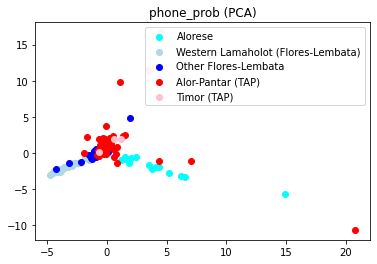

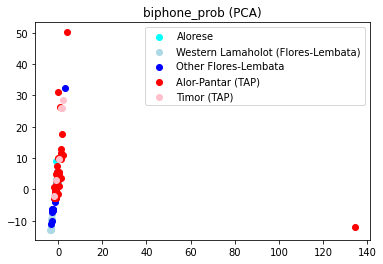

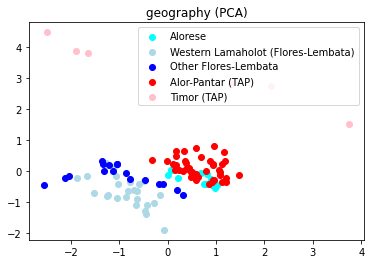

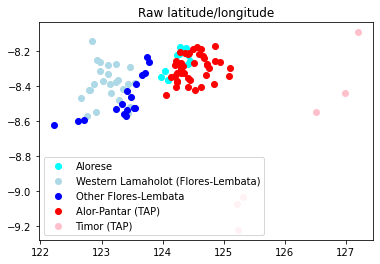

In [5]:
# Todo: standardize?
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# def create_colors_labels(lects):
#     def color_lect(lect):
#         if lect in list(lects_tap["ID"]):
#             return "red", "Timor-Alor-Pantar"
#         elif lect in list(lects_alorese["ID"]):
#             return "black", "Alorese"
#         elif lect in list(lects_lamaholot_related["ID"]):
#             return "cyan", "Lamaholot"
#         else:
#             raise ValueError("Unsupported lect")
#     return [color_lect(lect) for lect in lects]

PLOT_LABELS = False

#TODO: check outliers, smaller dots, bigger plots
# TODO: Biphone prob with transition probabilities
        
language_groups = {"Alorese": {"color": "cyan", "lects": lects_alorese["ID"]},
                   "Western Lamaholot (Flores-Lembata)": {"color": "lightblue", "lects": lects_western_lamaholot["ID"]},
                   "Other Flores-Lembata": {"color": "blue", "lects": lects_flores_lembata["ID"]},
                   "Alor-Pantar (TAP)": {"color": "red", "lects": lects_alor_pantar["ID"]},
                   "Timor (TAP)": {"color": "pink", "lects": lects_timor["ID"]}
                  }

dim_reds = {"PCA": PCA(n_components=2)}#,"MDS": MDS()}

analyses = {"phone_prob": phone_prob_matrix,
            "biphone_prob": biphone_prob_matrix,
            "geography": data_agg[["Latitude", "Longitude"]].fillna(0)
            }

for study_label, matrix in analyses.items():
    for dr_label, dr in dim_reds.items():
        std_data = StandardScaler().fit_transform(matrix)
        red_data = dr.fit_transform(std_data)
        x = [i[0] for i in red_data]
        y = [i[1] for i in red_data]
        data_agg[f"{study_label}-{dr_label}-pc1"] = x
        data_agg[f"{study_label}-{dr_label}-pc2"] = y
        # Plot datapoints per language group, for correct label + color
        for lang_group in language_groups:
            lects_group = language_groups[lang_group]["lects"]
            color = language_groups[lang_group]["color"]
            data_group = data_agg[data_agg.index.isin(lects_group)]
            x = data_group[f"{study_label}-{dr_label}-pc1"]
            y = data_group[f"{study_label}-{dr_label}-pc2"]
            scatter = plt.scatter(x, y, color=color, label=lang_group)
            if PLOT_LABELS:
                for _, row in data_group.iterrows():
                    plt.annotate(row.name, xy=(row[f"{study_label}-{dr_label}-pc1"], row[f"{study_label}-{dr_label}-pc2"]))
        plt.title(f"{study_label} ({dr_label})")
        plt.legend()
        plt.show()
        
# Raw latitude+longitude
for lang_group in language_groups:
    lects_group = language_groups[lang_group]["lects"]
    color = language_groups[lang_group]["color"]
    data_group = data_agg[data_agg.index.isin(lects_group)]
    x = data_group[f"Longitude"]
    y = data_group[f"Latitude"]
    scatter = plt.scatter(x, y, color=color, label=lang_group)
    if PLOT_LABELS:
        for _, row in data_group.iterrows():
            plt.annotate(row.name, xy=(row[f"Longitude"], row[f"Latitude"]))
plt.title(f"Raw latitude/longitude")
plt.legend()
plt.show()